In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
print('numpy     :', np.__version__)
print('pandas    :', pd.__version__)
print('tensorflow:', tf.__version__)

numpy     : 1.20.3
pandas    : 1.3.4
tensorflow: 2.8.0


In [2]:
df = pd.read_csv('BTCUSDT-1h.csv', index_col=0)
close = np.array(df['close'])
high = np.array(df['high'])
low = np.array(df['low'])
df

,open,high,low,close,volume
date,,,,,
2017-08-18 00:00:00,4285.08,4340.62,4228.76,4286.53,337549.35
2017-08-18 01:00:00,4286.53,4286.53,4134.61,4243.59,304223.23
2017-08-18 02:00:00,4243.59,4298.64,4234.00,4267.59,230478.63
2017-08-18 03:00:00,4267.59,4308.70,4234.00,4292.39,271281.60
2017-08-18 04:00:00,4292.39,4292.39,4234.43,4287.92,216069.15
...,...,...,...,...,...
2022-03-08 20:00:00,38764.87,38897.68,38434.22,38512.51,70243606.77
2022-03-08 21:00:00,38512.50,38586.15,38388.73,38494.34,38326461.51
2022-03-08 22:00:00,38494.34,38642.74,38472.61,38552.29,18659067.41


### Algorithm to generate market profile

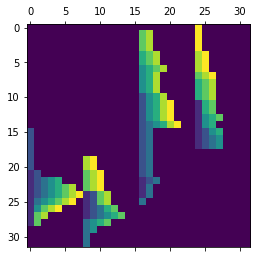

In [4]:
def market_profile(high, low, t, size, x_split):
    cut_list = np.linspace(0, size, x_split + 1).astype(int)
    split_len = int(size / x_split)
    matrix = np.array([[]])
    price_list = np.linspace(np.min(low[cut_list[0]:cut_list[-1]]),
                             np.max(high[cut_list[0]:cut_list[-1]]),
                             size)
    for c in range(1, len(cut_list)):
        h = high[cut_list[c - 1]:cut_list[c]]
        l = low[cut_list[c - 1]:cut_list[c]]
        out_array = np.full((size, split_len), 0)
        time_list = np.linspace(0, split_len, split_len + 1).astype(int)
        for i in range(1, len(time_list)):
            index = np.where((l[i-1] <= price_list) & (price_list <= h[i-1]))[0]
            for row in index:
                for column in range(split_len):
                    if out_array[row][column] == 0:
                        out_array[row][column] = i
                        break
        if c == 1:
            matrix = out_array
        else:
            matrix = np.hstack((matrix, out_array))
    return matrix.astype(np.float32)
T = 8
SIZE = 32
SPLIT = 4
tpo = market_profile(high, low, T, SIZE, SPLIT)
plt.matshow(tpo)
plt.show()

### Generate dataset

In [5]:
x = []
gray_scale = np.linspace(0.6, 1, SIZE)
for i in range(SIZE, len(close)-T):
    # generate TPO
    tpo = market_profile(high[i-SIZE:i], low[i-SIZE:i], T, SIZE, SPLIT)
    # change grayscale
    tpo[tpo > 0] = 1
    for i in range(len(tpo[0])):
        tpo[:, i] = tpo[:, i] * gray_scale[i]
    x.append(tpo)
x = np.array(x)
# np.save('x.npy', x)
# x = np.load('x.npy')
x.shape

(39897, 32, 32)

### Generate label

In [6]:
r = 0.02
y = []
for i in range(SIZE, len(close)-T):
    if (1-r)*close[i-T] > close[i] > (1+r)*close[i+T]:
        y.append(0)
    elif (1+r)*close[i-T] < close[i] < (1-r)*close[i+T]:
        y.append(2)
    else:
        y.append(1)
y = np.array(y)
np.save('y.npy', y)
y = np.load('y.npy')
y.shape

(39897,)

### Reshape x y & Split data

In [7]:
x = x.reshape(x.shape[0], SIZE, SIZE, 1)
print(x.shape)
onehot_y = np.zeros((y.size, 3))
onehot_y[np.arange(y.size), y] = 1
print(onehot_y.shape)

(39897, 32, 32, 1)
(39897, 3)


In [8]:
split = int(0.6 * len(close))
x_train = x[:split]
y_train = onehot_y[:split]
x_test = x[split:]
y_test = onehot_y[split:]
print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test: ', y_test.shape)

x_train:  (23962, 32, 32, 1)
y_train:  (23962, 3)
x_test:  (15935, 32, 32, 1)
y_test:  (15935, 3)


### Initialize model

In [9]:
batch_size = 128
shape = (SIZE,SIZE,1)
model = keras.Sequential([
    keras.layers.Conv2D(6, 5),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.ReLU(),
    keras.layers.Conv2D(16, 5),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.ReLU(),
    keras.layers.Conv2D(120, 5),
    keras.layers.Flatten(),
    keras.layers.Dense(84, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
model.build(input_shape=(batch_size, shape[0], shape[1], shape[2]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (128, 28, 28, 6)          156       
                                                                 
 max_pooling2d (MaxPooling2D  (128, 14, 14, 6)         0         
 )                                                               
                                                                 
 re_lu (ReLU)                (128, 14, 14, 6)          0         
                                                                 
 conv2d_1 (Conv2D)           (128, 10, 10, 16)         2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (128, 5, 5, 16)          0         
 2D)                                                             
                                                                 
 re_lu_1 (ReLU)              (128, 5, 5, 16)           0

### Training

In [10]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

# model.save('model.h5')
# model = keras.models.load_model('model.h5')

Epoch 1/50
749/749 [==============================] - 7s 9ms/step - loss: 0.2228 - accuracy: 0.9489 - val_loss: 0.1987 - val_accuracy: 0.9536
Epoch 2/50
749/749 [==============================] - 7s 9ms/step - loss: 0.2025 - accuracy: 0.9494 - val_loss: 0.1924 - val_accuracy: 0.9536
Epoch 3/50
749/749 [==============================] - 7s 9ms/step - loss: 0.1959 - accuracy: 0.9494 - val_loss: 0.1940 - val_accuracy: 0.9532
Epoch 4/50
749/749 [==============================] - 7s 9ms/step - loss: 0.1902 - accuracy: 0.9493 - val_loss: 0.2012 - val_accuracy: 0.9536
Epoch 5/50
749/749 [==============================] - 8s 10ms/step - loss: 0.1812 - accuracy: 0.9497 - val_loss: 0.2031 - val_accuracy: 0.9527
Epoch 6/50
749/749 [==============================] - 7s 9ms/step - loss: 0.1743 - accuracy: 0.9503 - val_loss: 0.2090 - val_accuracy: 0.9470
Epoch 7/50
749/749 [==============================] - 7s 10ms/step - loss: 0.1642 - accuracy: 0.9503 - val_loss: 0.2151 - val_accuracy: 0.9491
Epoc

### Predict

In [11]:
loss, acc = model.evaluate(x_test, y_test)
print('Loss    :', loss)
print('Accuracy:', acc)
pred = model.predict(x_test)
pred

498/498 [==============================] - 2s 3ms/step - loss: 0.9846 - accuracy: 0.9184
Loss    : 0.98464035987854
Accuracy: 0.9184185862541199


array([[1.8460431e-13, 9.9787235e-01, 2.1276628e-03],
       [1.2165652e-11, 9.9787915e-01, 2.1209195e-03],
       [6.4708956e-20, 9.9999988e-01, 5.9984188e-08],
       ...,
       [4.8676662e-12, 1.0000000e+00, 3.6253613e-12],
       [1.1380997e-08, 1.0000000e+00, 5.9226557e-09],
       [1.3211167e-13, 9.9999964e-01, 3.0932367e-07]], dtype=float32)

### Evaluate performance

In [22]:
price = np.array(close[SIZE+split:])
y_pred = np.round(pred[:,2] - pred[:, 0], 2)
return_log = np.cumsum(y_pred * ((price[T:] / price[:-T]) - 1)) + 1
print('Return:', return_log[-1])

Return: 3.1725044520055166


In [ ]:
turnover = np.mean(np.abs(y_pred[1:] - y_pred[:-1]))
print('Turnover:', turnover)

### Visualization

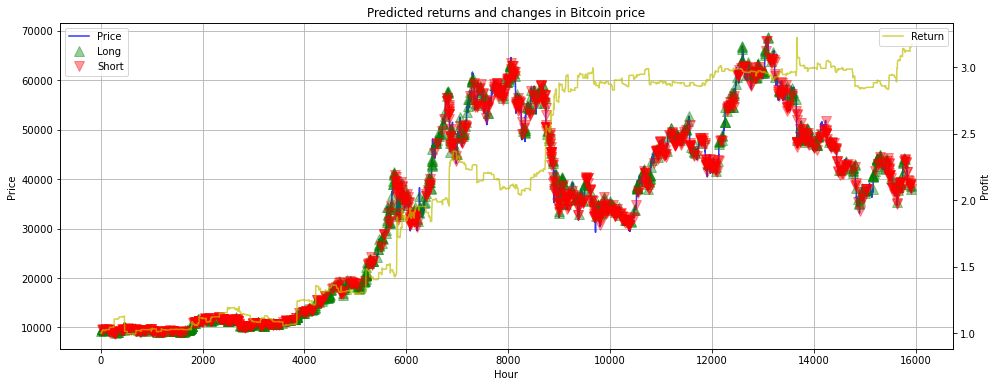

In [20]:
plot_df = pd.DataFrame({'price': price[:-T], 'return': return_log})

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(111)
plot_df['price'].plot(ax=ax1,grid=True,alpha=0.8,style='b',label='Price')
plt.xlabel('Hour')
ax1.set_ylabel('Price')

plt.plot(np.where(y_pred>0)[0], price[np.where(y_pred>0)[0]], '^', markersize=10, color='g', alpha=0.4, label='Long')
plt.plot(np.where(y_pred<0)[0], price[np.where(y_pred<0)[0]], 'v', markersize=10, color='r', alpha=0.4, label='Short')
plt.legend(loc=2)

ax2 = ax1.twinx()
plot_df['return'].plot(ax=ax2,label='Return',style='y',alpha=0.7)
ax2.set_ylabel('Profit')
plt.legend(loc=1)
plt.title('Predicted returns and changes in Bitcoin price')
plt.savefig('result.png', dpi=400, bbox_inches='tight')